# Reading dataset and combining tables

In [78]:
import pandas as pd
import numpy as np
import os
from scipy.stats import poisson
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

directory = 'C:/Users/99451/Desktop/MODEL/old/eng_l2'

dfs = []

# Define the columns you want to extract from each CSV file
columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'FTR', 'HST', 'AST', 'B365H', 'B365D', 'B365A']

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(directory, filename), on_bad_lines = 'skip', encoding='latin-1')
        df = df[columns_to_keep]
        dfs.append(df)

my_df = pd.concat(dfs, ignore_index=True)

print("Number of rows:", my_df.shape[0])
print("Number of columns:", my_df.shape[1])
my_df.head(5)

Number of rows: 12178
Number of columns: 13


,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,FTR,HST,AST,B365H,B365D,B365A
0,10/08/02,Boston,Bournemouth,2.0,2.0,0.0,1.0,D,2.0,5.0,2.400,3.20,2.600
1,10/08/02,Cambridge,Darlington,1.0,2.0,1.0,1.0,A,5.0,7.0,1.909,3.25,3.500
2,10/08/02,Carlisle,Hartlepool,1.0,3.0,0.0,1.0,A,3.0,4.0,2.375,3.20,2.625
3,10/08/02,Hull,Southend,2.0,2.0,1.0,0.0,D,6.0,7.0,1.533,3.50,5.500
4,10/08/02,Kidderminster,Lincoln,1.0,1.0,0.0,1.0,D,10.0,6.0,1.571,3.40,5.500


# Adding Moving Average Columns

In [79]:
#Creating a copy of my_df to work on
df = my_df.copy()

#Calculating Points Per Game for Home and Away Teams
df['HPTS'] = np.select([df['FTR'] == 'H', df['FTR'] == 'D', df['FTR'] == 'A'], [3, 1, 0], default=0)
df['APTS'] = np.select([df['FTR'] == 'H', df['FTR'] == 'D', df['FTR'] == 'A'], [0, 1, 3], default=0)

df['HPPG'] = df.groupby('HomeTeam')['HPTS'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['APPG'] = df.groupby('AwayTeam')['APTS'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['form_dif'] = df['HPPG'] - df['APPG'] #calculating form difference home points per game - away points per game

#Calculating scored and conceded goals
df['FTHGS'] = df.groupby('HomeTeam')['FTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['FTHGC'] = df.groupby('HomeTeam')['FTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['FTAGS'] = df.groupby('AwayTeam')['FTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['FTAGC'] = df.groupby('AwayTeam')['FTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

#Calculating scored and conceded goals for halftime
df['HTHGS'] = df.groupby('HomeTeam')['HTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['HTHGC'] = df.groupby('HomeTeam')['HTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['HTAGS'] = df.groupby('AwayTeam')['HTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['HTAGC'] = df.groupby('AwayTeam')['HTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

#Calculating shots on target for home/away
df['HSTS'] = df.groupby('HomeTeam')['HST'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['HSTC'] = df.groupby('HomeTeam')['AST'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['ASTS'] = df.groupby('AwayTeam')['AST'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['ASTC'] = df.groupby('AwayTeam')['HST'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['st_dif'] = df['HSTS'] - df['ASTS']

#Calculating odds probabilities
total = 1 / df['B365H'] + 1 / df['B365D'] + 1 / df['B365A']

df['FTH'] = (1 / df['B365H']) / total
df['FTD'] = (1 / df['B365D']) / total
df['FTA'] = (1 / df['B365A']) / total
df['FTDA'] = df['FTD'] + df['FTA']

# Calculate the league-wide moving average for home_goals and away_goals
df['league_home_goals'] = df['FTHG'].rolling(50, min_periods=1).mean().shift(1)
df['league_away_goals'] = df['FTAG'].rolling(50, min_periods=1).mean().shift(1)

df['ht_league_home_goals'] = df['HTHG'].rolling(50, min_periods=1).mean().shift(1)
df['ht_league_away_goals'] = df['HTAG'].rolling(50, min_periods=1).mean().shift(1)

#Calculating Poisson Statistics for Full/Halftime
df['home_attack'] = df['FTHGS'] / df['league_home_goals']
df['home_defence'] = df['FTHGC'] / df['league_away_goals']
df['away_attack'] = df['FTAGS'] / df['league_away_goals']
df['away_defence'] = df['FTAGC'] / df['league_home_goals']

df['ht_home_attack'] = df['HTHGS'] / df['ht_league_home_goals']
df['ht_home_defence'] = df['HTHGC'] / df['ht_league_away_goals']
df['ht_away_attack'] = df['HTAGS'] / df['ht_league_away_goals']
df['ht_away_defence'] = df['HTAGC'] / df['ht_league_home_goals']

df['home_xg'] = df['home_attack'] * df['away_defence'] * df['league_home_goals']
df['away_xg'] = df['away_attack'] * df['home_defence'] * df['league_away_goals']

df['ht_home_xg'] = df['ht_home_attack'] * df['ht_away_defence'] * df['ht_league_home_goals']
df['ht_away_xg'] = df['ht_away_attack'] * df['ht_home_defence'] * df['ht_league_away_goals']

df.dropna(inplace = True)
df = df.reset_index(drop = True)

df['home_poisson'] = df['home_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['away_poisson'] = df['away_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['ht_home_poisson'] = df['ht_home_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['ht_away_poisson'] = df['ht_away_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['poisson_df'] = df['home_poisson'] - df['away_poisson']
df['ht_poisson_df'] = df['ht_home_poisson'] - df['ht_away_poisson']
df['FTRT'] = [1 if x == 'H' else 0 for x in df['FTR']]

#Removing unnessary columns
df.drop(['Date', 'FTHG', 'FTAG', 'HPTS', 'APTS', 'FTHGS', 'FTHGC', 'FTAGS', 'FTAGC',
            'FTD', 'FTA', 'league_home_goals', 'league_away_goals', 'home_attack', 'home_defence', 'FTDA',
            'away_attack', 'away_defence', 'home_xg', 'away_xg', 'HPPG', 'APPG', 'home_poisson', 'away_poisson',
            'HST', 'AST', 'HSTC', 'ASTC', 'HTHG', 'HTAG', 'FTR', 'HSTS', 'ASTS',
            'ht_league_home_goals', 'ht_league_away_goals', 'ht_home_attack', 'ht_home_defence', 'ht_away_attack',
            'ht_away_defence', 'ht_home_xg', 'ht_away_xg', 'ht_home_poisson', 'ht_away_poisson',
            'HTHGS', 'HTHGC', 'HTAGS', 'HTAGC'], axis = 1, inplace = True)

df[df['HomeTeam'] == 'Hull'].head(7)

,HomeTeam,AwayTeam,B365H,B365D,B365A,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT
15,Hull,Bury,1.667,3.40,4.50,1.00,-2.00,0.537421,1,2,0
30,Hull,Leyton Orient,1.833,3.25,3.75,1.00,0.50,0.487140,1,0,0
54,Hull,Carlisle,1.615,3.40,5.00,-1.00,4.00,0.556174,0,0,1
65,Hull,Macclesfield,1.571,3.50,5.00,0.75,2.75,0.567197,2,1,0
91,Hull,Swansea,1.571,3.40,5.50,1.00,4.00,0.572182,1,1,0
116,Hull,Rochdale,2.300,3.20,2.70,-1.00,0.00,0.389014,-1,1,1
141,Hull,Rushden & D,2.000,3.25,3.25,0.60,2.60,0.448276,2,1,0


# Applying Normalization for Certain Columns

In [80]:
# Columns to normalize
cols_to_normalize = ['form_dif', 'st_dif', 'poisson_df', 'ht_poisson_df']

# Min-max normalization
df[cols_to_normalize] = df[cols_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df[df['HomeTeam'] == 'Hull'].head(7)

,HomeTeam,AwayTeam,B365H,B365D,B365A,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT
15,Hull,Bury,1.667,3.40,4.50,0.666667,0.264368,0.537421,0.500000,0.727273,0
30,Hull,Leyton Orient,1.833,3.25,3.75,0.666667,0.408046,0.487140,0.500000,0.545455,0
54,Hull,Carlisle,1.615,3.40,5.00,0.333333,0.609195,0.556174,0.416667,0.545455,1
65,Hull,Macclesfield,1.571,3.50,5.00,0.625000,0.537356,0.567197,0.583333,0.636364,0
91,Hull,Swansea,1.571,3.40,5.50,0.666667,0.609195,0.572182,0.500000,0.636364,0
116,Hull,Rochdale,2.300,3.20,2.70,0.333333,0.379310,0.389014,0.333333,0.636364,1
141,Hull,Rushden & D,2.000,3.25,3.25,0.600000,0.528736,0.448276,0.583333,0.636364,0


# Starting ML Tests with Random Forests


Random Forest - Training Accuracy: 0.7734399335479182
Random Forest - Test Accuracy: 0.5805647840531561


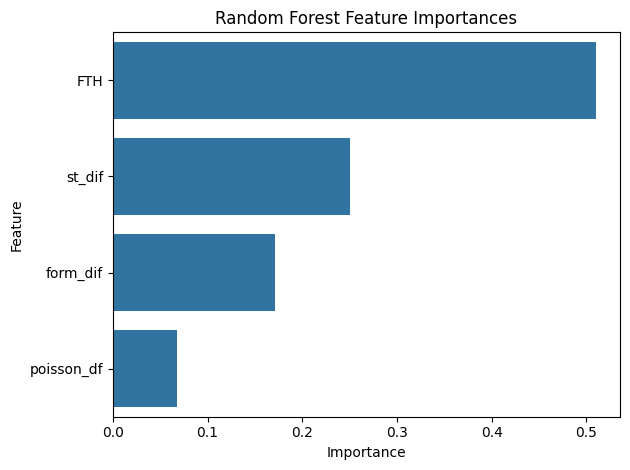

              precision    recall  f1-score   support

           0       0.63      0.64      0.63      1378
           1       0.51      0.51      0.51      1030

    accuracy                           0.58      2408
   macro avg       0.57      0.57      0.57      2408
weighted avg       0.58      0.58      0.58      2408

Confusion Matrix:
[[877 501]
 [509 521]]
ROC AUC Score: 0.571127425423084


In [81]:
# Split the data into training and testing sets
X = df.drop(columns=['FTRT', 'HomeTeam', 'AwayTeam', 'ht_poisson_df', 'B365H', 'B365D', 'B365A'], axis = 1)  # Features
y = df['FTRT']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Random Forest
rf_model = BalancedRandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10, min_samples_leaf=10, random_state=42,
                                          sampling_strategy = 'all', replacement = True, bootstrap = False)

# Train models
rf_model.fit(X_train, y_train)

# Predictions
rf_train_preds = rf_model.predict(X_train)
rf_test_preds = rf_model.predict(X_test)

# Accuracy scores
rf_train_accuracy = accuracy_score(y_train, rf_train_preds)
rf_test_accuracy = accuracy_score(y_test, rf_test_preds)

print("\nRandom Forest - Training Accuracy:", rf_train_accuracy)
print("Random Forest - Test Accuracy:", rf_test_accuracy)

rf_feature_importances = rf_model.feature_importances_

# Visualize feature importances
rf_feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_feature_importances})

sns.barplot(x='Importance', y='Feature', data=rf_feature_importances_df.sort_values(by='Importance', ascending=False))
plt.title('Random Forest Feature Importances')

plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(y_test, rf_test_preds))

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(y_test, rf_test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, rf_test_preds)
print("ROC AUC Score:", roc_auc)

# Trying with Different Models

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Define models and their hyperparameter grids
models_and_parameters = {
    'Logistic Regression': (
        LogisticRegression(solver='liblinear'),
        {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}
    ),
    'Random Forest': (
        RandomForestClassifier(),
        {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
    ),
    'Support Vector Machine': (
        SVC(probability=True),
        {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    ),
    'Gradient Boosting': (
        GradientBoostingClassifier(),
        {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
    ),
    'XGBoost': (
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        {
            'n_estimators': [100, 200, 300, 400],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 10, 20]
        })
}

# Store results
grid_search_results = {}

for name, (model, param_grid) in models_and_parameters.items():
    print(f"Running GridSearchCV for {name}...")
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1  # Use all available cores
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    y_preds = best_model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    test_accuracy = accuracy_score(y_test, y_preds)
    
    grid_search_results[name] = {
        'best_params': grid_search.best_params_,
        'roc_auc': roc_auc,
        'accuracy': test_accuracy
    }

# Print results
print("\n📊 ROC AUC Scores and Best Parameters:")
for name, result in grid_search_results.items():
    print(f"{name}: Test Accuracy = {result['accuracy']:.4f} | Best Params: {result['best_params']}")


Running GridSearchCV for Logistic Regression...
Running GridSearchCV for Random Forest...
Running GridSearchCV for Support Vector Machine...
Running GridSearchCV for Gradient Boosting...
Running GridSearchCV for XGBoost...

📊 ROC AUC Scores and Best Parameters:
Logistic Regression: Test Accuracy = 0.6022 | Best Params: {'C': 0.1, 'penalty': 'l1'}
Random Forest: Test Accuracy = 0.5905 | Best Params: {'max_depth': 10, 'n_estimators': 100}
Support Vector Machine: Test Accuracy = 0.5901 | Best Params: {'C': 10, 'kernel': 'rbf'}
Gradient Boosting: Test Accuracy = 0.6009 | Best Params: {'learning_rate': 0.01, 'n_estimators': 200}
XGBoost: Test Accuracy = 0.6034 | Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


# Trying with Best Model (Support Vector Machine)


✅ ROC AUC Score: 0.5920

✅ Test Accuracy: 0.5901

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.89      0.71      1378
           1       0.56      0.18      0.28      1030

    accuracy                           0.59      2408
   macro avg       0.58      0.54      0.50      2408
weighted avg       0.58      0.59      0.53      2408


🧩 Confusion Matrix:
[[1232  146]
 [ 841  189]]


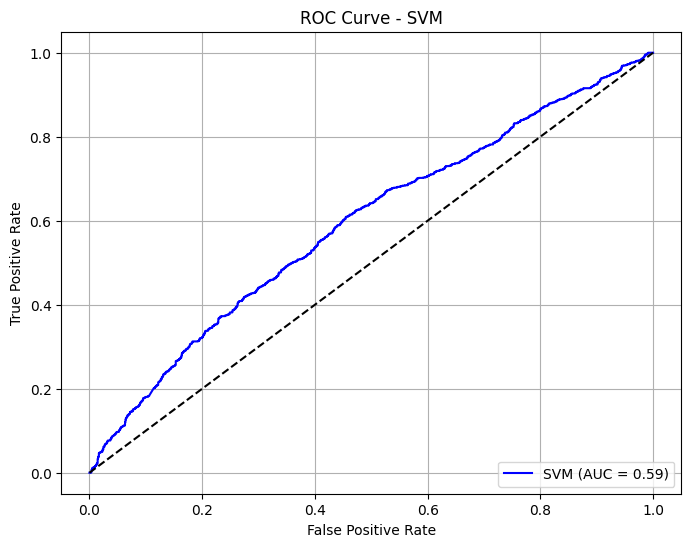

In [84]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Train the best SVM model
best_svm = SVC(C=10, kernel='rbf', probability=True)
best_svm.fit(X_train, y_train)

# Predict probabilities and classes
svm_pred_proba = best_svm.predict_proba(X_test)[:, 1]
svm_pred = best_svm.predict(X_test)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, svm_pred_proba)
accuracy = accuracy_score(y_test, svm_pred)
print(f"\n✅ ROC AUC Score: {roc_auc:.4f}")
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

# Classification report
print("\n📄 Classification Report:")
print(classification_report(y_test, svm_pred))

# Confusion Matrix
print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_test, svm_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, svm_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Trying with 2nd Best Model (Logistic Regression)

ROC AUC Score: 0.6189383798103343

✅ Test Accuracy: 0.5839
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.61      0.63      1378
           1       0.51      0.55      0.53      1030

    accuracy                           0.58      2408
   macro avg       0.58      0.58      0.58      2408
weighted avg       0.59      0.58      0.59      2408



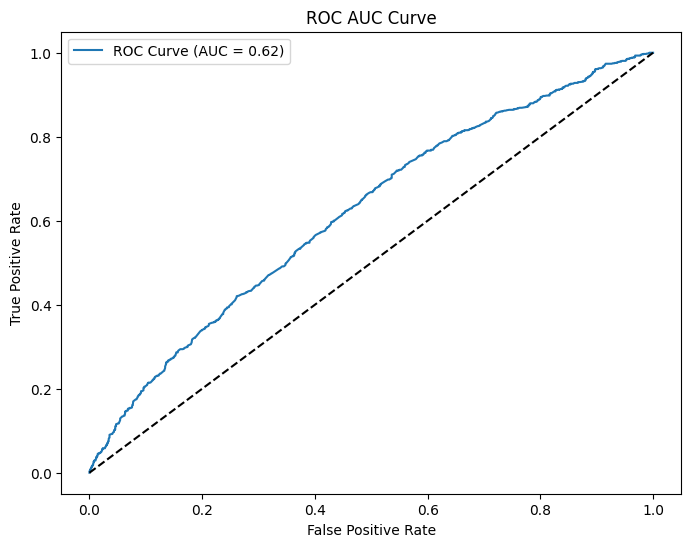

[[840 538]
 [464 566]]


In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# Initialize and train Logistic Regression model with best hyperparameters
logistic_regression = LogisticRegression(C=0.1, class_weight='balanced', penalty='l1', solver='liblinear')
logistic_regression.fit(X_train, y_train)

# Generate predictions on the test set
log_pred_proba = logistic_regression.predict_proba(X_test)[:, 1]
log_pred = logistic_regression.predict(X_test)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, log_pred_proba)
accuracy = accuracy_score(y_test, log_pred)
print("ROC AUC Score:", roc_auc)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, log_pred))

# Plot ROC AUC curve
fpr, tpr, thresholds = roc_curve(y_test, log_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()
plt.show()

print(confusion_matrix(y_test, log_pred))

# Calculating Profitability for the Original Dataframe

In [86]:
#Merging predictions with test set
merged_df = df.loc[X_test.index].copy()
merged_df['svm_pred'] = svm_pred
merged_df['log_pred'] = log_pred
merged_df[merged_df['svm_pred'] != merged_df['log_pred']].head()

,HomeTeam,AwayTeam,B365H,B365D,B365A,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT,svm_pred,log_pred
218,Bournemouth,Hull,1.833,3.25,3.75,0.800000,0.551724,0.487140,0.416667,0.545455,0,0,1
2342,Chester,Brentford,2.100,3.20,3.20,0.477778,0.314176,0.432432,0.416667,0.545455,0,0,1
5862,Scunthorpe,AFC Wimbledon,1.850,3.75,4.50,0.666667,0.459770,0.525088,0.500000,0.636364,0,0,1
9349,Mansfield,Bradford,2.150,3.50,3.30,0.666667,0.379310,0.441345,0.500000,0.545455,0,0,1
8416,Grimsby,Morecambe,2.250,3.40,3.50,0.600000,0.540230,0.433911,0.500000,0.636364,0,0,1


In [87]:
# Conditions Checking for profitability
cond_1 = (merged_df['FTRT'] == merged_df['log_pred']) & (merged_df['log_pred'] == 1) #change log to svm when needed
cond_2 = (merged_df['FTRT'] == merged_df['log_pred']) & (merged_df['log_pred'] == 0)
cond_3 = merged_df['FTRT'] != merged_df['log_pred']

# Choices
choice_1 = merged_df['B365H'] - 1
choice_2 = (1 / ((1 / merged_df['B365D']) + (1 / merged_df['B365A']))) * 0.95 - 1
choice_3 = -1

# Assign new column
merged_df['Profit'] = np.select([cond_1, cond_2, cond_3], [choice_1, choice_2, choice_3])
merged_df['Proba'] = log_pred_proba #change this too
print(merged_df['Profit'].sum())
print(merged_df['Profit'].sum() / len(merged_df['Profit']))
merged_df.head()

-196.91125751791864
-0.08177377803900276


,HomeTeam,AwayTeam,B365H,B365D,B365A,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT,svm_pred,log_pred,Profit,Proba
6066,Morecambe,Scunthorpe,3.50,3.25,2.10,0.333333,0.448276,0.267123,0.416667,0.545455,0,0,0,0.211916,0.361101
3780,Morecambe,Grimsby,1.83,3.50,4.33,0.800000,0.643678,0.514009,0.500000,0.454545,0,1,1,-1.000000,0.573301
11847,Bromley,Fleetwood Town,2.25,3.30,3.10,0.533333,0.413793,0.415347,0.416667,0.545455,1,0,0,-1.000000,0.487325
2619,Grimsby,Chesterfield,2.37,3.20,2.75,0.600000,0.482759,0.384254,0.416667,0.545455,1,0,0,-1.000000,0.460143
8516,Notts County,Cheltenham,2.37,3.30,3.30,0.633333,0.482759,0.410448,0.500000,0.545455,0,0,0,0.567500,0.483032


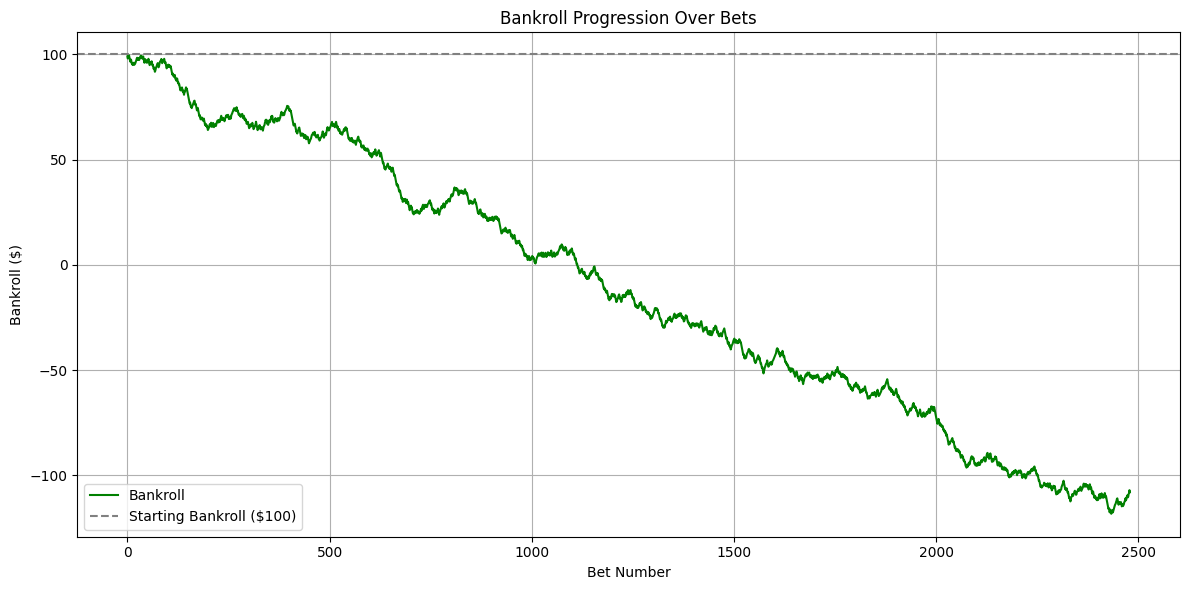

,HomeTeam,AwayTeam,B365H,B365D,B365A,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT,svm_pred,log_pred,Profit,Proba,Bankroll
2316,Leicester,Luton,1.75,3.30,4.20,0.600000,0.463158,0.513619,0.55,0.454545,0,0,1,-1.000000,0.580685,99.000000
1121,Sheffield United,Coventry,1.83,3.20,4.00,0.433333,0.494737,0.492763,0.55,0.454545,0,1,1,-1.000000,0.584189,98.000000
4560,Reading,Middlesbrough,1.91,3.40,4.00,0.433333,0.557895,0.490373,0.50,0.454545,1,0,1,0.910000,0.575179,98.910000
11809,Swansea,Rotherham,1.36,4.75,9.50,0.800000,0.589474,0.699558,0.70,0.818182,1,1,1,0.360000,0.757073,99.270000
8664,Hull,Leeds,3.60,3.60,2.14,0.333333,0.389474,0.271574,0.40,0.363636,0,0,0,0.275052,0.331223,99.545052


In [68]:
import matplotlib.pyplot as plt

# Start with $100
starting_bankroll = 100

# Calculate cumulative bankroll
merged_df['Bankroll'] = starting_bankroll + merged_df['Profit'].cumsum()

# Plot it
plt.figure(figsize=(12, 6))
plt.plot(range(len(merged_df)), merged_df['Bankroll'], label='Bankroll', color='green')

# Optional: add horizontal line for starting bankroll
plt.axhline(y=starting_bankroll, color='gray', linestyle='--', label='Starting Bankroll ($100)')

# Labels and title
plt.xlabel('Bet Number')
plt.ylabel('Bankroll ($)')
plt.title('Bankroll Progression Over Bets')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

merged_df.head()

# Continuing with Pred Probas

In [48]:
profit_margin = 0.05

# Continue with pred_proba of the model
merged_df['exp_odds'] = np.where(
    merged_df['log_pred'] == 1,
    1 / merged_df['Proba'],
    1 / (1 - merged_df['Proba'])
)

merged_df['bookie_odds'] = np.where(
    merged_df['log_pred'] == 1,
    merged_df['B365H'],
    (1 / ((1 / merged_df['B365D']) + (1 / merged_df['B365A']))) * 0.95
)

merged_df['ev_bet'] = np.where(merged_df['exp_odds'] > (merged_df['bookie_odds'] + merged_df['bookie_odds'] * profit_margin), 1, 0)

merged_df.head()

,HomeTeam,AwayTeam,B365H,B365D,B365A,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT,svm_pred,log_pred,Profit,Proba,Bankroll,exp_odds,bookie_odds,ev_bet,edge
4952,Liverpool,West Brom,1.40,4.75,10.0,0.533333,0.510870,0.696992,0.352941,0.500000,0,1,1,-1.000000,0.711347,99.000000,1.405784,1.400000,0,-0.012885
6701,Man United,Crystal Palace,1.30,5.50,9.5,0.766667,0.586957,0.728223,0.529412,0.583333,0,1,1,-1.000000,0.745135,98.000000,1.342039,1.300000,0,0.014149
6742,Man United,Chelsea,2.37,3.60,2.8,0.433333,0.315217,0.399240,0.352941,0.583333,0,0,0,0.496250,0.435022,98.496250,1.769979,1.496250,1,0.093655
222,Sunderland,Southampton,2.50,3.20,2.5,0.433333,0.347826,0.359551,0.294118,0.500000,0,0,0,0.333333,0.405490,98.829583,1.682057,1.333333,1,0.178528
5521,Burnley,West Brom,2.25,3.30,3.6,0.633333,0.369565,0.433498,0.352941,0.500000,0,0,0,0.635652,0.475712,99.465236,1.907348,1.635652,1,0.082543


C:\Users\99451\AppData\Local\Temp\ipykernel_13592\4021871502.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_bets['Bankroll'] = starting_bankroll + ev_bets['Profit'].cumsum()


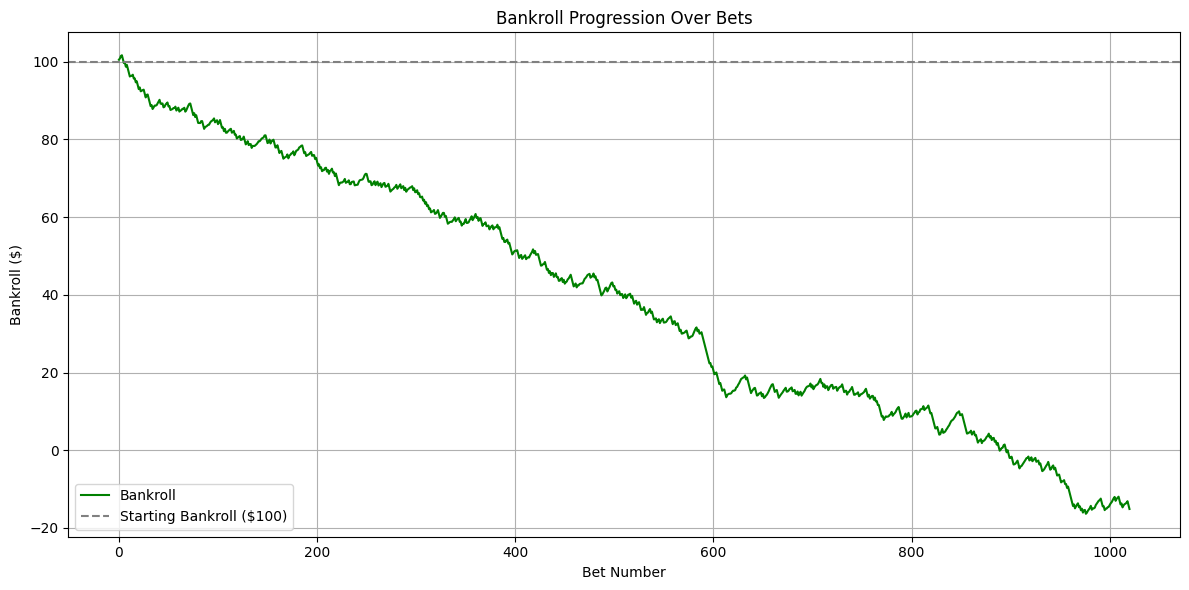

-115.11368129825402
-0.11274601498359846


,HomeTeam,AwayTeam,B365H,B365D,B365A,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT,svm_pred,log_pred,Profit,Proba,Bankroll,exp_odds,bookie_odds,ev_bet,edge
6742,Man United,Chelsea,2.37,3.60,2.8,0.433333,0.315217,0.399240,0.352941,0.583333,0,0,0,0.496250,0.435022,100.496250,1.769979,1.496250,1,0.093655
222,Sunderland,Southampton,2.50,3.20,2.5,0.433333,0.347826,0.359551,0.294118,0.500000,0,0,0,0.333333,0.405490,100.829583,1.682057,1.333333,1,0.178528
5521,Burnley,West Brom,2.25,3.30,3.6,0.633333,0.369565,0.433498,0.352941,0.500000,0,0,0,0.635652,0.475712,101.465236,1.907348,1.635652,1,0.082543
8195,Arsenal,Everton,1.18,8.00,12.0,0.833333,0.554348,0.802676,0.470588,0.583333,1,1,1,0.180000,0.788917,101.645236,1.267560,1.180000,1,0.051756
2758,Burnley,West Ham,2.60,3.25,2.8,0.566667,0.434783,0.366492,0.352941,0.500000,1,0,0,-1.000000,0.425857,100.645236,1.741726,1.428926,1,0.137420


In [49]:
ev_bets = merged_df[merged_df['ev_bet'] == 1]

# Start with $100
starting_bankroll = 100

# Calculate cumulative bankroll
ev_bets['Bankroll'] = starting_bankroll + ev_bets['Profit'].cumsum()

# Plot it
plt.figure(figsize=(12, 6))
plt.plot(range(len(ev_bets)), ev_bets['Bankroll'], label='Bankroll', color='green')

# Optional: add horizontal line for starting bankroll
plt.axhline(y=starting_bankroll, color='gray', linestyle='--', label='Starting Bankroll ($100)')

# Labels and title
plt.xlabel('Bet Number')
plt.ylabel('Bankroll ($)')
plt.title('Bankroll Progression Over Bets')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(ev_bets['Profit'].sum())
print(ev_bets['Profit'].sum() / len(ev_bets['Profit']))
ev_bets.head()

# Trying To Optimize Profit Using Odds Differences

0.5244361718177055 -0.16450461623260293


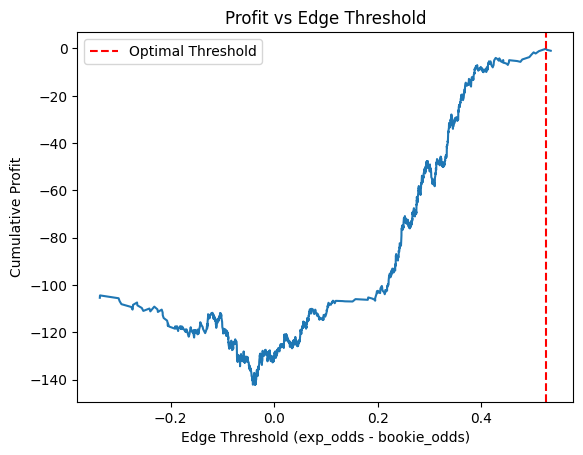

,HomeTeam,AwayTeam,B365H,B365D,B365A,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT,svm_pred,log_pred,Profit,Proba,Bankroll,exp_odds,bookie_odds,ev_bet,edge
445,Bolton,Birmingham,2.40,3.20,2.70,0.566667,0.728261,0.378947,0.352941,0.5,0,0,0,0.391186,0.478578,34.741364,1.917833,1.391186,1,0.526646
179,Aston Villa,Middlesbrough,2.25,3.25,2.75,0.800000,0.641304,0.398329,0.411765,0.5,1,0,0,-1.000000,0.486933,10.673937,1.949065,1.415104,1,0.533961
337,Man City,West Ham,2.20,3.40,2.75,0.566667,0.641304,0.408654,0.352941,0.5,0,0,0,0.444309,0.492062,11.555692,1.968745,1.444309,1,0.524436


In [50]:
merged_df['edge'] = merged_df['exp_odds'] - merged_df['bookie_odds']
df_sorted = merged_df.sort_values(by='edge', ascending=False).reset_index(drop=True)
df_sorted['cum_profit'] = df_sorted['Profit'].cumsum()
max_profit_idx = df_sorted['cum_profit'].idxmax()

optimal_edge_threshold = df_sorted.loc[max_profit_idx, 'edge']
max_profit = df_sorted.loc[max_profit_idx, 'cum_profit']
print(optimal_edge_threshold, max_profit)

optimal_df = merged_df[merged_df['edge'] >= optimal_edge_threshold]

plt.plot(df_sorted['edge'], df_sorted['cum_profit'])
plt.xlabel('Edge Threshold (exp_odds - bookie_odds)')
plt.ylabel('Cumulative Profit')
plt.title('Profit vs Edge Threshold')
plt.axvline(optimal_edge_threshold, color='red', linestyle='--', label='Optimal Threshold')
plt.legend()
plt.show()

optimal_df.head()